In [1]:
%config InlineBackend.figure_format='retina'

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import torch
import pickle

from lrm_steering.lrm_models.feature_extractor import *
from reprGeo_default.scripts.data_utils import *
from reprGeo_default.scripts.metrics import *
from reprGeo_default.scripts.viz import *

numCate = 100
imagesPerCate = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
idx2label, idx2number, number2label = load_imagenet_label_maps('/teamspace/studios/this_studio/imagenet_class_index.json')

# Load Model & Transformation, Create DataLoader 

In [4]:
# path to dataset
dataset_path = f'/teamspace/studios/this_studio/imageData/{numCate}*{imagesPerCate}_imageNet_train_random'

# Load the pre-trained alexnet_lrm3 model (without steering)
model, transforms = torch.hub.load('cindyluo99/lrm-steering:dev', 'alexnet_lrm3', pretrained=True, steering=False, force_reload=True)
val_transform = transforms['val_transform'] # should i change it to train?

val_dataloader = create_dataLoader(dataset_path, val_transform, idx2number, 100, 4)

Downloading: "https://github.com/cindyluo99/lrm-steering/zipball/dev" to /home/zeus/.cache/torch/hub/dev.zip


==> Loading weights for alexnet_lrm3, hash_id=63ab1b3b06
https://s3.us-east-1.wasabisys.com/visionlab-projects/dnn_feedback_dev/logs/set15/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps/28453e80-c5e5-4d76-bc81-99c5fade39ff/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps_final_weights-63ab1b3b06.pth
local_filename: /home/zeus/.cache/torch/hub/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps_final_weights-63ab1b3b06.pth
<All keys matched successfully>


# Get activations from the layer of interest

In [ ]:
model.to(device)
model.eval()
layer_of_interest = 'feedforward.classifier.6' #last layer
feature_extractor = FeatureExtractor(model, layer_of_interest, device=device)

# acc 81.57%
activations_1, categories_1, labels_1, accuracy_1 = get_activation(model, val_dataloader, layer_of_interest, feature_extractor, number2label, device, 1, True)
# acc 81.02%
activations_2, categories_2, labels_2, accuracy_2 = get_activation(model, val_dataloader, layer_of_interest, feature_extractor, number2label, device, 2, True)
# acc 82.19%
activations_3, categories_3, labels_3, accuracy_3 = get_activation(model, val_dataloader, layer_of_interest, feature_extractor, number2label, device, 3, True)

## save activations/labels as torch tensors & store, save categories as pickle file

In [ ]:
torch.save(activations_1, f'reprGeo_output/activations_pass1_imagenettrain_{numCate}*{imagesPerCate}.pt')
torch.save(activations_2, f'reprGeo_output/activations_pass2_imagenettrain_{numCate}*{imagesPerCate}.pt')
torch.save(activations_3, f'reprGeo_output/activations_pass3_imagenettrain_{numCate}*{imagesPerCate}.pt')
torch.save(labels_1, f'reprGeo_output/labels_pass1_imagenettrain_{numCate}*{imagesPerCate}.pt')
with open(f'reprGeo_output/categories_{numCate}*{imagesPerCate}.pkl', 'wb') as f:
    pickle.dump(categories_1, f)

## load stored activations & labels 

In [5]:
activations_1 = torch.load(f'reprGeo_output/activations_pass1_imagenettrain_{numCate}*{imagesPerCate}.pt')
# activations_2 = torch.load(f'reprGeo_output/activations_pass2_imagenettrain_{numCate}*{imagesPerCate}.pt')
activations_3 = torch.load(f'reprGeo_output/activations_pass3_imagenettrain_{numCate}*{imagesPerCate}.pt')
labels_1 = torch.load(f'reprGeo_output/labels_pass1_imagenettrain_{numCate}*{imagesPerCate}.pt')
# with open(f'reprGeo_output/categories_{numCate}*{imagesPerCate}.pkl', 'rb') as f:
#     categories_1 = pickle.load(f)

# Prototype/Centroid Calculation

In [6]:
unique_labels = torch.unique(labels_1).tolist()

prototypes_1pass = compute_prototypes(activations_1, labels_1, unique_labels)
prototypes_3pass = compute_prototypes(activations_3, labels_1, unique_labels)

# Examplar-to-Prototype Distances

## Calculation

In [13]:
# Compute distances to prototypes before and after modulation
distances_before_cos = compute_exemplar_distances(activations_1, prototypes_1pass, labels_1, unique_labels, "cosine")
# distances_after_proto2_cos = compute_distances(activations_2, prototypes_2pass, labels_1, "cosine")
distances_after_proto3_cos = compute_exemplar_distances(activations_3, prototypes_3pass, labels_1, unique_labels, "cosine")

In [14]:
# Compute distances to prototypes before and after modulation
distances_before_euc = compute_exemplar_distances(activations_1, prototypes_1pass, labels_1, unique_labels, "euclidean")
# distances_after_proto2_euc = compute_distances(activations_2, prototypes_2pass, labels_1, "euclidean")
distances_after_proto3_euc = compute_exemplar_distances(activations_3, prototypes_3pass, labels_1, unique_labels, "euclidean")

## Stats Testing & Plot

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_diff
No. Observations: 30000   Method:             REML         
No. Groups:       100     Scale:              0.0017       
Min. group size:  300     Log-Likelihood:     52866.5643   
Max. group size:  300     Converged:          Yes          
Mean group size:  300.0                                    
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept   -0.036     0.002  -19.569  0.000  -0.040  -0.033
Group Var    0.000     0.001                                

One-tailed p-value: 1.415288461179036e-85


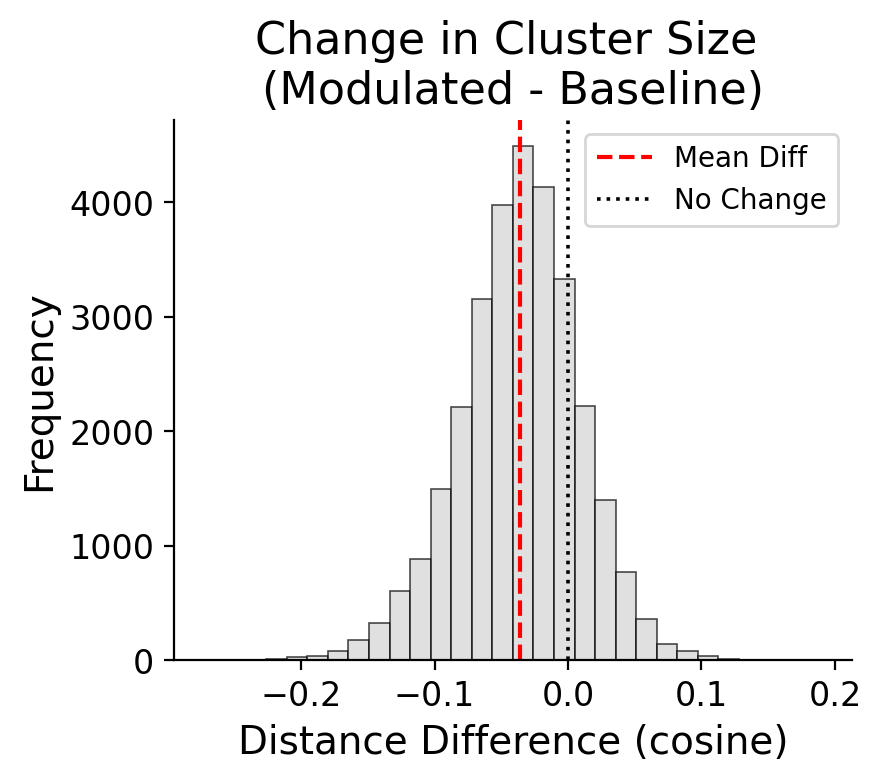

{'mean_diff': -0.03615822467604676, 'p_one_tailed': 1.415288461179036e-85}

In [61]:
plot_distance_change_histogram(
    distances_baseline=distances_before_cos,  # Pass 1 distances
    distances_modulated=distances_after_proto3_cos, # Pass 3 distances
    category_labels=labels_1,
    dist_metric_name="cosine"
)

# Nearest Neighbors

## Prepare the similarity matrix

In [7]:
sim_act1 = get_cosine_sim_mtx(activations_1, device)
sim_act3 = get_cosine_sim_mtx(activations_3, device)

In [ ]:
recall, cat_pres = get_recall_and_shared_cat_preserve(sim_act1, sim_act3, labels_1, device, return_cate=True, ks=range(2,301))

In [8]:
category_preservation_at_k_1 = get_category_preservation(sim_act1, labels_1)
category_preservation_at_k_3 = get_category_preservation(sim_act3, labels_1)

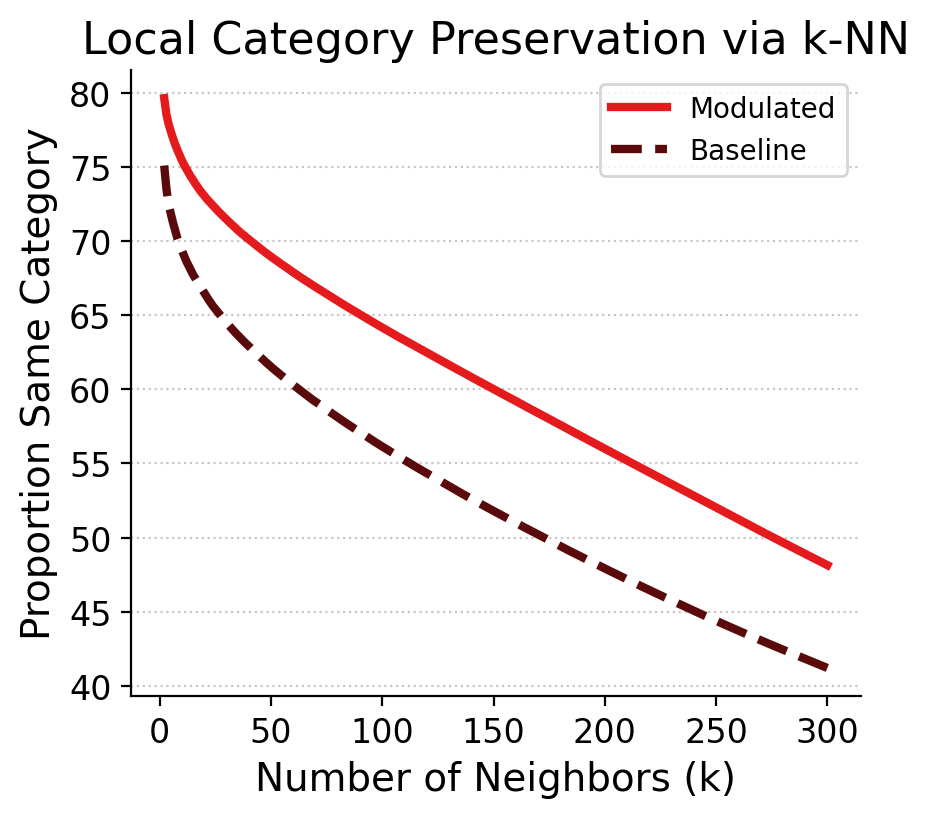

In [20]:
plot_category_preservation_curve(range(2, 301), category_preservation_at_k_1, category_preservation_at_k_3)

# Pairwise Distance Change between images

In [25]:
# sim_act1, sim_act3: your N×N cosine‐sim torch tensors
# labels_1: long tensor [N] with values in 0..numCate-1
mat = get_cate_distance_change_matrix(sim_act1, sim_act3, labels_1, unique_labels)
# mat[i,j] is the average change (after−before) for category‐i vs category‐j

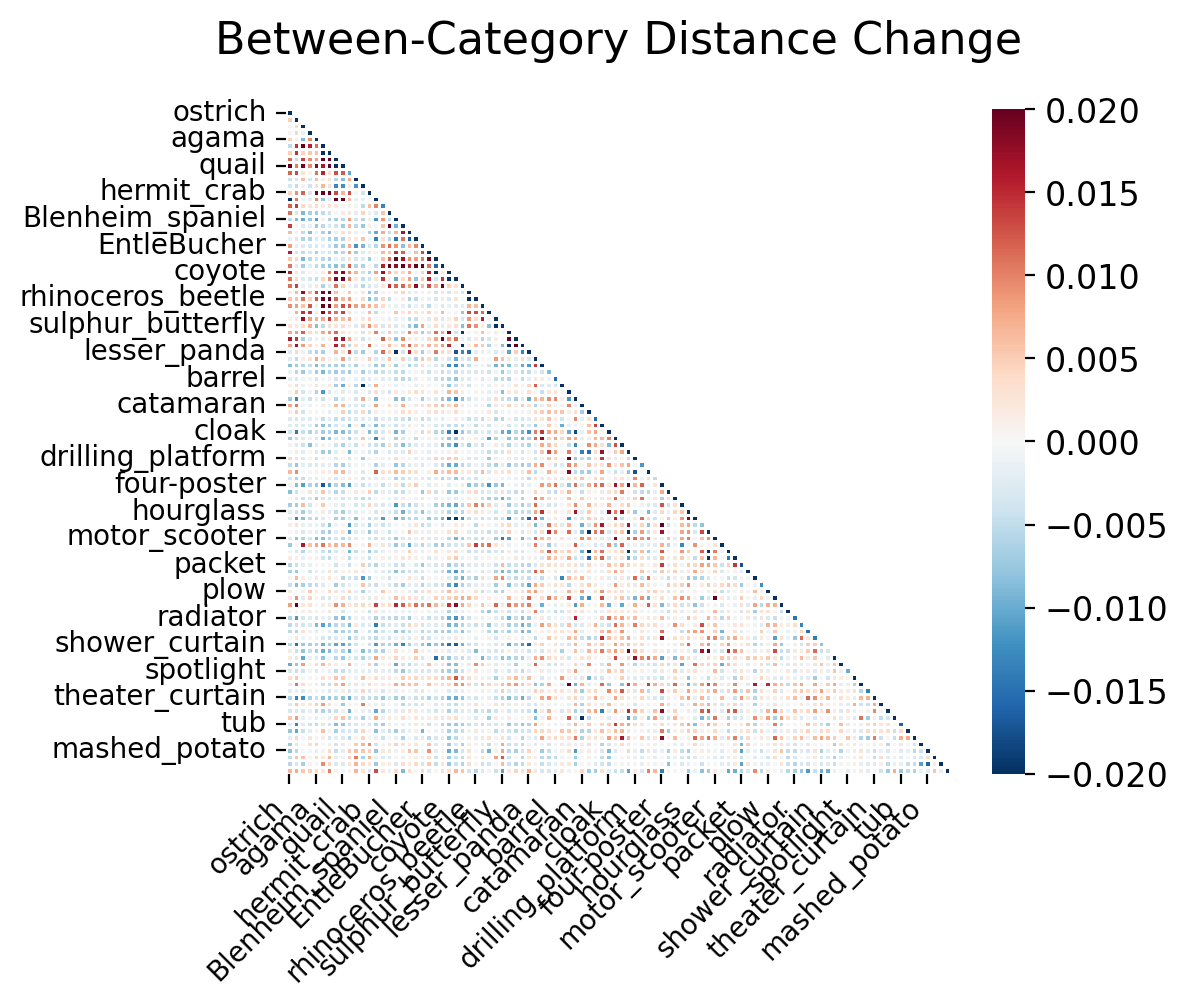

In [37]:
plot_category_distance_change_heatmap(
    mat, unique_labels,number2label,
    tick_spacing=4,
    cmap='RdBu_r',
    vmin=-0.02,vmax=0.02,
    save_path='reprGeo_default/figures/'
)

# Global Geometry: PCA & Protype Shifts

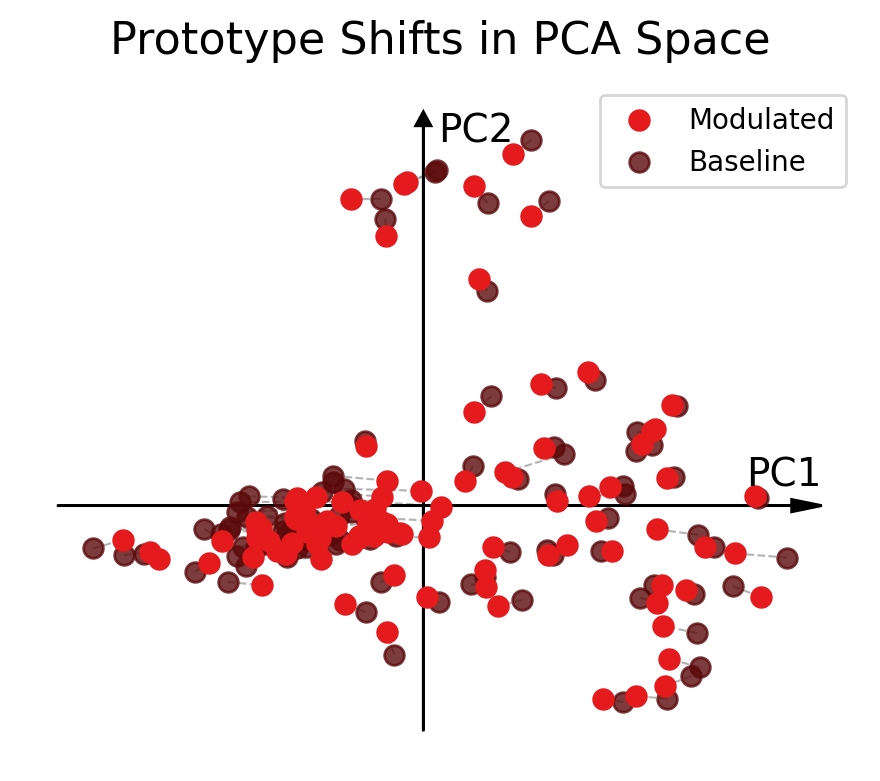

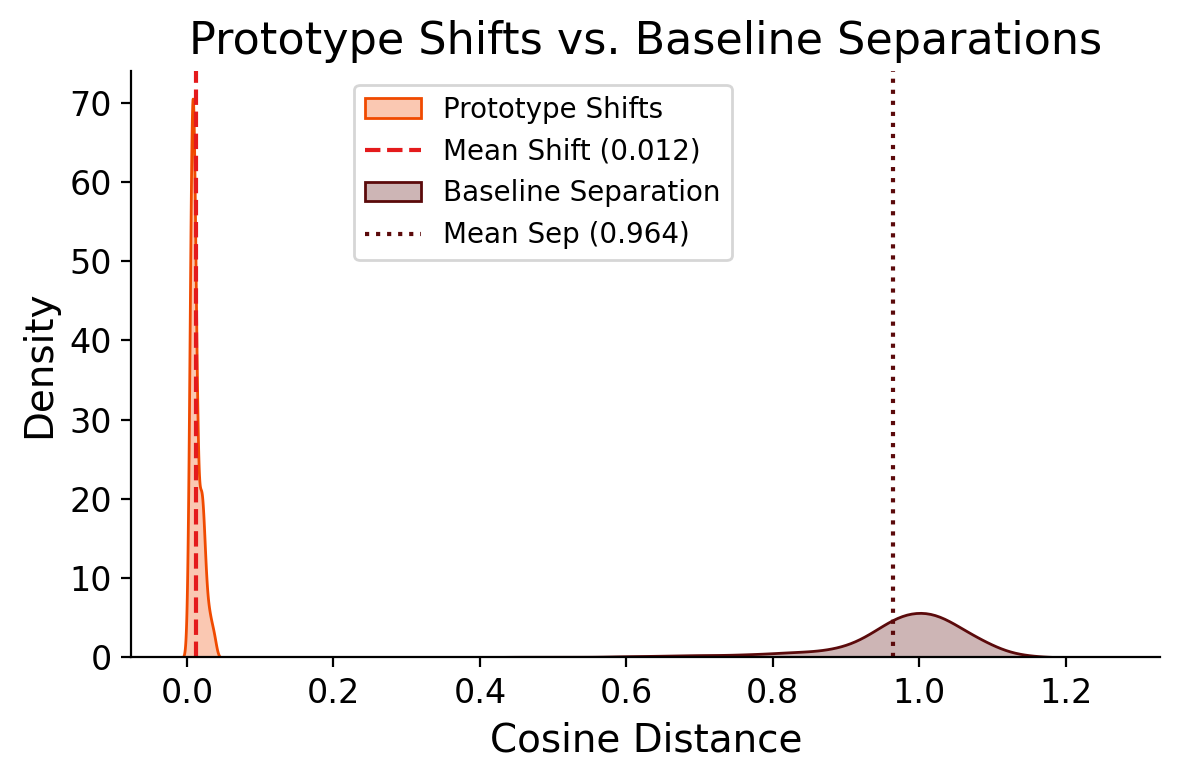

In [63]:

# metrics
shifts = compute_prototype_shifts(prototypes_1pass, prototypes_3pass)
sep_base, sep_delta = compute_between_prototype_changes(prototypes_1pass, prototypes_3pass)
rho, pval = calculate_rsa_torch(prototypes_1pass, prototypes_3pass)

# plots
plot_prototype_shift_pca(prototypes_1pass, prototypes_3pass, activations_1, activations_3, pca_on='baseline')
plot_shift_vs_separation_kde(
    shifts.cpu().numpy(),
    sep_base.cpu().numpy(),
)

In [48]:
print(rho, pval)

0.9527387111530675 0.0


# Exploratory: Local Compaction & Global Shifts

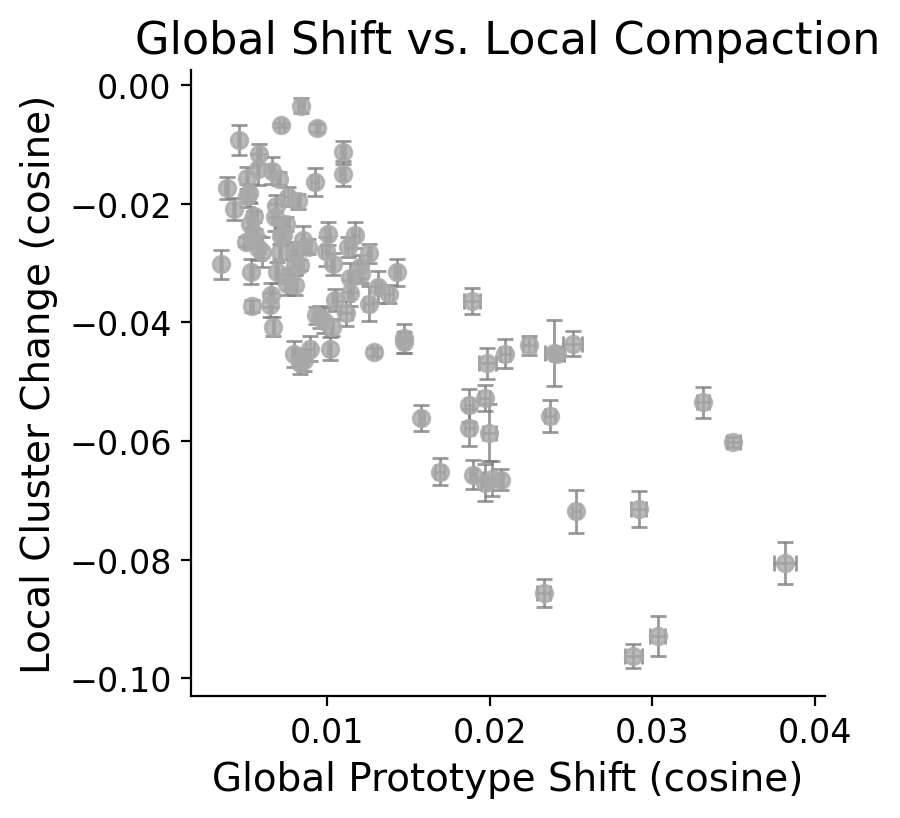

In [58]:
loc_avg, glo_avg, loc_all, glo_all = cross_validation_analysis(
    activations_1, activations_3, labels_1, unique_labels, k=5
)

plot_local_global_correlation(
    global_avg=glo_avg,
    local_avg=loc_avg,
    global_all=glo_all,
    local_all=loc_all,
    error_type='sem',
    annotate=False,
    save_path='reprGeo_default/figures/'
)